In [1]:
%load_ext autoreload
%autoreload 2

import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import blackjax
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jaxoplanet.light_curves import LimbDarkLightCurve
from corner import corner
import pickle

from jaxoplanet import orbits

from kernelsearch import describe_kernel, get_trainables
from inference import log_likelihood_function, run_inference_algorithm
from util import calculate_example_lightcurve

plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]


rng_key = jax.random.PRNGKey(42)

## LOAD DATA AND MODEL

In [2]:
(
    t_train,
    lc_train,
    train_mask,
    t,
    lightcurve,
    systematics,
    noise,
    mask,
) = calculate_example_lightcurve()

with open("gpmodel", "rb") as file:
    model = pickle.load(file)

describe_kernel(model)

'(Periodic * Linear * Linear) + Periodic'

## FIT LC

In [3]:
@jit
def lc_model(t, log_params):
    params = jnp.exp(log_params)

    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=15,
        radius=params[0],
        inclination=jnp.deg2rad(89),
        time_transit=0,
    )

    lc = LimbDarkLightCurve([params[1], params[2]]).light_curve(orbit, t=t)
    return lc

In [4]:
from tensorflow_probability.substrates.jax.distributions import (
    Normal,
    Uniform,
    TransformedDistribution,
)
from tensorflow_probability.substrates.jax.bijectors import Log

initial_params = {
    "gp_parameter": get_trainables(model, unconstrain=True),
    "lc_parameter": jnp.log(jnp.asarray([0.2, 0.2, 0.5])),
}

(lower_param_bounds, upper_param_bounds) = (
    {
        "gp_parameter": -jnp.inf * jnp.ones_like(initial_params["gp_parameter"]),
        "lc_parameter": jnp.array([-10.0, -10.0, -10.0]),
    },
    {
        "gp_parameter": jnp.inf * jnp.ones_like(initial_params["gp_parameter"]),
        "lc_parameter": jnp.array([0.0, 0.0, 0.0]),
    },
)

param_priors = {
    "gp_parameter": Normal(loc=initial_params["gp_parameter"], scale=1),
    "lc_parameter": TransformedDistribution(
        distribution=Uniform(
            low=jnp.exp(lower_param_bounds["lc_parameter"]),  # type: ignore
            high=jnp.exp(upper_param_bounds["lc_parameter"]),  # type: ignore
        ),
        bijector=Log(),
    ),
}

In [5]:
log_likelihood = log_likelihood_function(
    model.unconstrain(),
    lc_model,
    t_train,
    lc_train,
    train_mask,
    fix_gp=False,
    compile=True,
)


@jit
def log_priors(params):
    gp_log_priors = param_priors["gp_parameter"].log_prob(params["gp_parameter"])
    lc_log_priors = param_priors["lc_parameter"].log_prob(params["lc_parameter"])
    return jnp.sum(gp_log_priors) + jnp.sum(lc_log_priors)


@jit
def log_probability(params):
    return log_likelihood(params) + log_priors(params)


neg_log_probability = jit(lambda params: -log_probability(params))

In [6]:
from jaxopt import ScipyBoundedMinimize

lbfgsb = ScipyBoundedMinimize(fun=neg_log_probability, method="l-bfgs-b")
lbfgsb_sol = lbfgsb.run(initial_params, bounds=(lower_param_bounds, upper_param_bounds))

jnp.exp(lbfgsb_sol.params["lc_parameter"])

Array([0.10041802, 0.22677938, 0.43477522], dtype=float64)

## RUN MCMC

In [7]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 500
num_samples = 200
num_chains = 8

warmup = blackjax.window_adaptation(
    blackjax.nuts,
    log_probability,
    target_acceptance_rate=0.65,
    progress_bar=True,
)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(
    warmup_key,
    initial_params,
    num_steps=num_adapt,
)

Running window adaptation


In [ ]:
nuts = blackjax.nuts(log_probability, **parameters)

initial_positions = {
    "gp_parameter": jnp.tile(state.position["gp_parameter"], (num_chains, 1)),
    "lc_parameter": jnp.tile(state.position["lc_parameter"], (num_chains, 1)),
}

initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

inference_loop_multiple_chains = jax.pmap(
    run_inference_algorithm,
    in_axes=(0, 0, None, None, None),
    static_broadcasted_argnums=(2, 3, 4),
)
sample_keys = jax.random.split(sample_key, num_chains)

pmap_states = inference_loop_multiple_chains(
    sample_keys,
    initial_states,
    nuts,
    num_samples,
    False,
)

In [ ]:
pmap_states[1].position["lc_parameter"].reshape(-1, 3).shape

(800, 3)

/home/chris/mambaforge/envs/hobby/lib/python3.10/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


Done


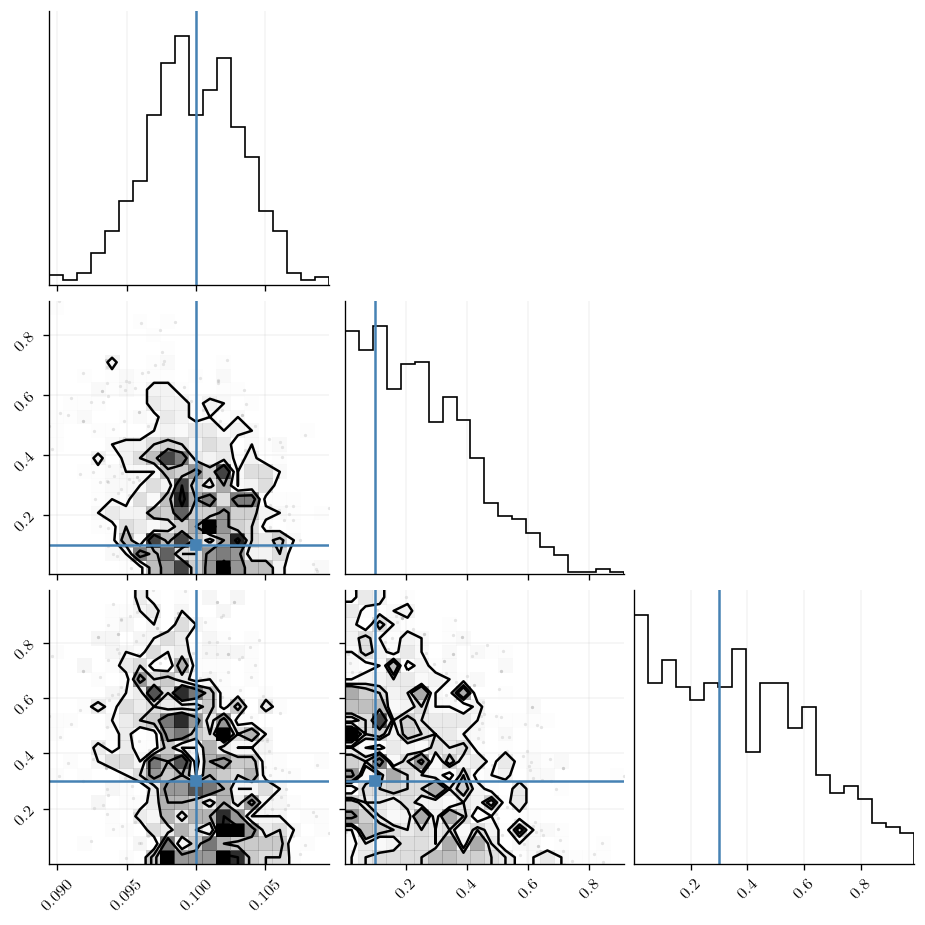

In [ ]:
corner(
    np.exp(np.array(pmap_states[1].position["lc_parameter"].reshape(-1, 3))),
    truths=jnp.array([0.1, 0.1, 0.3]),
)
print("Done")